# Putting the pieces of kicker data together 
#### Matthew Johnson, August 13, 2018

In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, make_pipeline
warnings.filterwarnings('ignore')

kickers09to17 = pd.read_csv('kicker_data_09_17.csv')
weather09to13 = pd.read_csv('weather_data09to13.csv') 
vegas09to17 = pd.read_csv('vegas_odds09to17.csv') # Weeks 6-16

dfs = [kickers09to17, weather09to13, vegas09to17]
dfs[1].drop('Unnamed: 0', axis=1, inplace=True)
dfs[2].drop('Unnamed: 0', axis=1, inplace=True)

In [52]:
mergecodes = []
mergecodes2 = []

for df in dfs:
    print (df.shape)
    mergecodes.append(list(df['mergeCode'].unique()))
    mergecodes2.append(list(df['mergeCode2'].unique()))

(2642, 65)
(2058, 16)
(2878, 10)


In [53]:
# A - kicker data
# B - weather
# C - vegas odds

A = set(mergecodes[0])
B = set(mergecodes[1])
sd = A.symmetric_difference(B)
intersect1 = A.intersection(B)
print('A:', len(A), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect1))

A = set(mergecodes[0])
C = set(mergecodes[2])
sd = A.symmetric_difference(C)
intersect2 = A.intersection(C)
print('A:', len(A), 'C:', len(C), 'sym_diff:', len(sd), 'intersect:', len(intersect2))

C = set(mergecodes[2])
B = set(mergecodes[1])
sd = C.symmetric_difference(B)
intersect3 = C.intersection(B)
print('C:', len(C), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect3))

intersect_all = intersect1.intersection(C)
print('int_all:', len(intersect_all))

A: 2642 B: 2058 sym_diff: 2160 intersect: 1270
A: 2642 C: 2873 sym_diff: 1013 intersect: 2251
C: 2873 B: 2058 sym_diff: 2223 intersect: 1354
int_all: 1199


In [54]:
# A - kicker data
# B - weather
# C - vegas odds

A = set(mergecodes2[0])
B = set(mergecodes2[1])
sd = A.symmetric_difference(B)
intersect1 = A.intersection(B)
print('A:', len(A), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect1))

A = set(mergecodes2[0])
C = set(mergecodes2[2])
sd = A.symmetric_difference(C)
intersect2 = A.intersection(C)
print('A:', len(A), 'C:', len(C), 'sym_diff:', len(sd), 'intersect:', len(intersect2))

C = set(mergecodes2[2])
B = set(mergecodes2[1])
sd = C.symmetric_difference(B)
intersect3 = C.intersection(B)
print('C:', len(C), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect3))

intersect_all = intersect1.intersection(C)
print('int_all:', len(intersect_all))

A: 2640 B: 2052 sym_diff: 2032 intersect: 1330
A: 2640 C: 2872 sym_diff: 898 intersect: 2307
C: 2872 B: 2052 sym_diff: 2422 intersect: 1251
int_all: 1214


In [56]:
df1 = pd.merge(dfs[0], dfs[1], on='mergeCode2', how='inner')
df2 = pd.merge(df1, dfs[2], on='mergeCode2', how='inner')
print(df2.shape)

(1232, 89)


In [71]:
offenseVariables = ['3rdDown_rate', 'Drive', 'FirstDown','Kicker_Pts',
    'TwoPointConv','Drive_rolling5', 'Kicker_Pts_rolling5', 
    'PointsScored_rolling5', 'Yards.Gained_rolling5', 'FG_range_per_drive', 'RZ_per_drive',
    'punts_per_drive', 'Completion_pct', 'TwoPoint_conv_rate']

defenseVariables = ['DEF_3rdDownSuccess_rolling5', 'DEF_Drive_rolling5', 'DEF_FirstDown_rolling5', 
    'DEF_Kicker_Pts_rolling5',  'DEF_Touchdown_rolling5', 
    'DEF_Yards.Gained_rolling5','DEF_FG_range_per_drive', 'DEF_RZ_per_drive', 'DEF_PointsScored_rolling5',
    'DEF_punts_per_drive', 'DEF_Completion_pct']

generalVariables = ['offenseTeam.1', 'defenseTeam_x', 'Season_x', 'Week_y', 'date_x', 
        'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity', 'wind_mph', 
        'home_team', 'Year', 
        'Relative_Line', 'Total', 'Exp_Pts', 'mergeCode', 'mergeCode2', 'mergeCode_x']

df_off = df2[offenseVariables]
df_def = df2[defenseVariables]
df_gen = df2[generalVariables]

df_gen.columns = ['offenseTeam', 'defenseTeam', 'Season', 'Week', 'date',
       'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity',
       'wind_mph', 'home_team', 'Year', 'Relative_Line', 'Total', 'Exp_Pts', 
       'mergeCode', 'mergeCode2', 'mergeCode_x']

data = pd.concat([df_gen, df_off, df_def], axis=1)
kicker_pts = df2['Kicker_Pts']

In [59]:
data.head()

,offenseTeam,defenseTeam,Season,Week,date,off_score,def_score,temperature,wind_chill,humidity,...,DEF_Drive_rolling5,DEF_FirstDown_rolling5,DEF_Kicker_Pts_rolling5,DEF_Touchdown_rolling5,DEF_Yards.Gained_rolling5,DEF_FG_range_per_drive,DEF_RZ_per_drive,DEF_PointsScored_rolling5,DEF_punts_per_drive,DEF_Completion_pct
0,ARI,NYG,2009,6,10/25,24,17,60,60.0,56.0,...,24.0,19.0,3.0,2.0,385.0,0.375000,0.208333,20.0,0.250000,0.0
1,ATL,DAL,2009,6,10/25,21,37,64,64.0,60.0,...,23.0,23.0,7.0,2.0,467.0,0.391304,0.260870,21.0,0.260870,0.0
2,BUF,CAR,2009,6,10/25,20,9,55,55.0,64.0,...,21.0,21.0,6.0,2.0,389.0,0.380952,0.190476,19.0,0.238095,0.0
3,CAR,BUF,2009,6,10/25,9,20,55,55.0,64.0,...,25.0,25.0,7.0,1.0,423.0,0.400000,0.200000,16.0,0.240000,0.0
4,CHI,CIN,2009,6,10/25,10,45,46,46.0,68.0,...,23.0,23.0,6.0,2.0,483.0,0.434783,0.086957,20.0,0.217391,0.0


In [61]:
data2 = data.drop(['off_score', 'def_score'], axis=1)
data2['Season'] = data2['Season'].astype('category')
data2['Week'] = data2['Week'].astype('category')
data2['Year'] = data2['Year'].astype('category')

num_data = data2.select_dtypes(include=['int64', 'float64'])

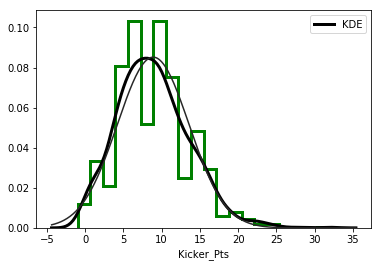

In [151]:
sns.distplot(kicker_pts, bins=20, fit=norm,
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"});

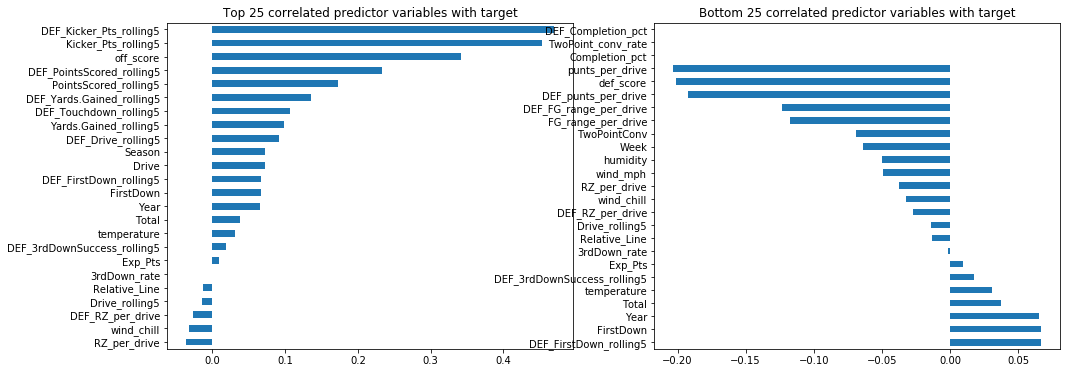

In [72]:
corr = data.corr()['Kicker_Pts']

corr_rank = corr.sort_values(ascending=False)

corr_rank_high = corr_rank[1:25]
corr_rank_low = corr_rank[-25:]

plt.subplots(figsize=(16,6))

plt.subplot(1, 2, 1)
highCorrs = corr_rank_high.sort_values(ascending=True)
highCorrs.plot(kind='barh')
plt.title('Top 25 correlated predictor variables with target')

plt.subplot(1, 2, 2)
inverseCorrs = corr_rank_low.sort_values(ascending=False)
inverseCorrs.plot(kind='barh')
plt.title('Bottom 25 correlated predictor variables with target');

### Modelling

In [93]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [138]:
from scipy.stats import norm, skew

all_data = num_data.drop(['Kicker_Pts', 'Relative_Line', 'TwoPoint_conv_rate'], axis=1)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
TwoPointConv,5.544
3rdDown_rate,4.776
DEF_3rdDownSuccess_rolling5,3.305
wind_mph,1.306
DEF_FirstDown_rolling5,0.344


In [140]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
#skewed_features = skewed_features.drop(['Relative_Line', 'TwoPoint_conv_rate'])
print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data = pd.concat([all_data, num_data['Relative_Line']], axis=1)

There are 29 skewed numerical features to Box Cox transform


In [144]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

all_data['3rdDown_rate'].fillna(all_data['3rdDown_rate'].mean(), inplace=True)
all_data['wind_chill'].fillna(all_data['temperature'], inplace=True)

X = all_data
y = kicker_pts

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 2018)
rf2.fit(Xtrain, ytrain);

In [145]:
predictions = rf2.predict(Xtest)
errors = abs(predictions - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 2.98


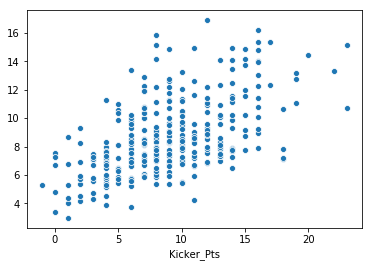

In [150]:
sns.scatterplot(x=ytest, y=predictions);

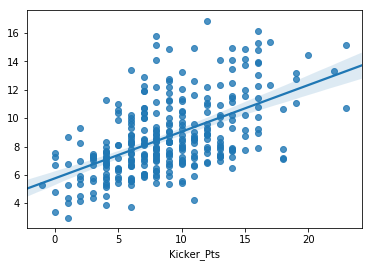

In [149]:
sns.regplot(x=ytest, y=predictions);